In [17]:
import os
import umap
import random
import sklearn
import gensim
import gensim.models
import pandas as pd
import numpy as np


from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MeanShift


%matplotlib inline

In [60]:
train_data_file = "./data_HC/menon_train_data.csv"
train_label_file = "./data_HC/menon_train_label.csv"
valid_data_file = "./data_HC/menon_validation_data.csv"
valid_label_file = "./data_HC/menon_validation_label.csv"
test_data_file = "./data_HC/lukowski_test_data.csv"
test_label_file = None

In [5]:
classes_tree = pd.read_csv("./data_HC/classes_tree.csv").fillna("Unknown")
classes_tree

,Root,Level 1,Level 2,Level 3,Level 4
0,Eye,Unknown,Unknown,Unknown,Unknown
1,Unknown,Nerve cell,Unknown,Unknown,Unknown
2,Unknown,Unknown,Neuron,Unknown,Unknown
3,Unknown,Unknown,Unknown,Photoreceptor cell,Unknown
4,Unknown,Unknown,Unknown,Unknown,Rod cell
5,Unknown,Unknown,Unknown,Unknown,Cone cell
6,Unknown,Unknown,Unknown,Bipolar cell,Unknown
7,Unknown,Unknown,Unknown,Unknown,Amacrine cell
8,Unknown,Unknown,Unknown,Unknown,Horizontal cell
9,Unknown,Unknown,Unknown,Ganglion cell,Unknown


In [6]:
n_levels = classes_tree.shape[1]
n_levels

BATCH_SIZE = 1024
N_EPOCHS = 40

In [7]:
def Get_level_label(n_levels = n_levels, classes_tree = classes_tree):
    level_label = dict()
    level_label_value = dict()
    for i in range(n_levels):
        labels = np.unique(classes_tree.iloc[:,i])
        level_label[i] = dict()
        level_label_value[i] = dict()
        for j in range(labels.shape[0]):
            level_label[i][labels[j]] = np.eye(labels.shape[0])[j]
            level_label_value[i][j] = labels[j]
    return level_label, level_label_value

level_label, level_label_value = Get_level_label(n_levels, classes_tree)
print(level_label)
print(level_label_value)

{0: {'Eye': array([1., 0.]), 'Unknown': array([0., 1.])}, 1: {'Epithelial cell': array([1., 0., 0.]), 'Nerve cell': array([0., 1., 0.]), 'Unknown': array([0., 0., 1.])}, 2: {'Endothelial cell': array([1., 0., 0., 0.]), 'Neuroglial cell': array([0., 1., 0., 0.]), 'Neuron': array([0., 0., 1., 0.]), 'Unknown': array([0., 0., 0., 1.])}, 3: {'Bipolar cell': array([1., 0., 0., 0., 0., 0.]), 'Ganglion cell': array([0., 1., 0., 0., 0., 0.]), 'Microglia': array([0., 0., 1., 0., 0., 0.]), 'Muller cell': array([0., 0., 0., 1., 0., 0.]), 'Photoreceptor cell': array([0., 0., 0., 0., 1., 0.]), 'Unknown': array([0., 0., 0., 0., 0., 1.])}, 4: {'Amacrine cell': array([1., 0., 0., 0., 0., 0.]), 'Cone cell': array([0., 1., 0., 0., 0., 0.]), 'Horizontal cell': array([0., 0., 1., 0., 0., 0.]), 'Retinal ganglion cell': array([0., 0., 0., 1., 0., 0.]), 'Rod cell': array([0., 0., 0., 0., 1., 0.]), 'Unknown': array([0., 0., 0., 0., 0., 1.])}}
{0: {0: 'Eye', 1: 'Unknown'}, 1: {0: 'Epithelial cell', 1: 'Nerve ce

In [61]:
train_data_df = pd.read_csv(train_data_file, index_col=0).fillna(-1)
train_label_df = pd.read_csv(train_label_file, index_col=0).fillna("Unknown")
valid_data_df = pd.read_csv(valid_data_file, index_col=0).fillna(-1)
valid_label_df = pd.read_csv(valid_label_file, index_col=0).fillna("Unknown")
test_data_df = pd.read_csv(test_data_file, index_col=0).fillna(-1)
test_label_df = None

In [9]:
print(train_label_df.shape)

(14346, 4)


In [10]:
mean = np.mean(train_data_df, axis = 0)

In [11]:
MEAN = 0
STD = 0
class CellDataset(Dataset):
    def __init__(self, data_df, label_df, is_train = True, is_test = False, mean = None, std = None):
        self.data_df = data_df
        self.label_df = label_df
        self.mean = None
        self.std = None
        self.is_train = is_train
        self.is_test = is_test
        if(is_train):
            self.mean = np.mean(data_df, axis = 0)
            self.std = np.std(data_df, axis = 0)
        else:
            self.mean = mean
            self.std = std
        #self.data_df = (self.data_df-self.mean)/(self.std+1e-12)
        MEAN = self.mean
        STD = self.std
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        data = self.data_df.iloc[idx,:].astype(np.float32)
        data = torch.from_numpy(np.array(data))
        labels = int(-1)
        if(not self.is_test):
            labels = list(self.label_df.iloc[idx,:])
            for i in range(len(labels)):
                labels[i] = level_label[i+1][labels[i]]
                labels[i] = torch.from_numpy(labels[i].astype(np.uint8))
                labels[i] = labels[i].unsqueeze(-1)

        return data, labels

In [12]:
class DenseCrossEntropy(nn.Module):

    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()

In [13]:
class CellModel(nn.Module):
    def __init__(self, input_size=2000, output_size=256):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        nn.init.kaiming_normal_(self.fc1.weight) # OPTIONAL
        self.fc2 = nn.Linear(1024, 512)
        nn.init.kaiming_normal_(self.fc2.weight) # OPTIONAL
        self.fc3 = nn.Linear(512, 256)
        nn.init.kaiming_normal_(self.fc3.weight) # OPTIONAL
        #self.fc4 = nn.Linear(256, 128)
        #nn.init.kaiming_normal_(self.fc3.weight) # OPTIONAL
        #self.fc5 = nn.Linear(128, 64)
        #nn.init.kaiming_normal_(self.fc3.weight) # OPTIONAL
        #self.fc6 = nn.Linear(64, 32)
        #nn.init.kaiming_normal_(self.fc3.weight) # OPTIONAL
               
    def forward(self, x):
        # forward always defines connectivity
        x = x.squeeze(-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output1 = F.relu(self.fc3(x))
        #output2 = F.relu(self.fc4(output1))
        #output3 = F.relu(self.fc5(output2))
        #output4 = F.relu(self.fc6(output3))
        return output1

In [14]:
dataset_train = CellDataset(train_data_df, train_label_df, is_train = True)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
dataset_valid = CellDataset(valid_data_df, valid_label_df, is_train = False, mean = MEAN, std = STD)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

In [62]:
dataset_test = CellDataset(test_data_df, test_label_df, is_train = False, is_test = True, mean = MEAN, std = STD)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

In [24]:
device = torch.device("cuda:0")
model = CellModel().to(device)

classifiers = []
#in_sizes = [0, 256, 128, 64, 32]
for item in level_label:
    if(item > 0):
        classifiers.append(nn.Linear(256, len(level_label[item])))
        nn.init.kaiming_normal_(classifiers[item-1].weight) # OPTIONAL
        classifiers[item-1] = classifiers[item-1].to(device)
        print(classifiers[item-1])
criterion = DenseCrossEntropy()
plist = [{'params': model.parameters(), 'lr': 5e-5}]
optimizer = optim.Adam(plist, lr=5e-5)

Linear(in_features=256, out_features=3, bias=True)
Linear(in_features=256, out_features=4, bias=True)
Linear(in_features=256, out_features=6, bias=True)
Linear(in_features=256, out_features=6, bias=True)


In [25]:
model

CellModel(
  (fc1): Linear(in_features=2000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
)

In [26]:
def train(model = model, classifiers = classifiers, criterion = criterion, optimizer = optimizer, dataloader = dataloader_train):
    loss_list = []
    accu_list = ([],[],[],[])
    f1_list = ([],[],[],[])
    for epoch in range(N_EPOCHS):
        model.train()
        tr_loss = 0
        
        tr_preds = []
        tr_labels = []
        for i in range(len(classifiers)):
            tr_preds.append(None)
            tr_labels.append(None)
        
        for step, batch in enumerate(dataloader_train):
            data = batch[0].to(device)
            label = batch[1]
            for i in range(len(label)):
                label[i] = label[i].to(device)
                if tr_labels[i] is None:
                    tr_labels[i] = label[i].clone().squeeze(-1).data.cpu().argmax(dim=1)
                else:
                    tr_labels[i] = torch.cat((tr_labels[i], label[i].clone().squeeze(-1).data.cpu().argmax(dim=1)), dim=0)
                
            output = model(data)
            loss = None
            for i in range(len(classifiers)):
                result = classifiers[i](output)
                if(loss is None):
                    loss = 2**(i)*criterion(result, label[i].squeeze(-1))
                else:
                    loss += 2**(i)*criterion(result, label[i].squeeze(-1))
    
                preds = torch.softmax(result, dim=1).data.cpu().argmax(dim=1)
                if(tr_preds[i] is None):
                    tr_preds[i] = preds
                else:
                    tr_preds[i] = torch.cat((tr_preds[i], preds), dim=0)
                    
            loss.backward()
            tr_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            loss_list.append(loss.item())
            print("Epoch %d, step %d, loss = %.4f"%(epoch, step, loss))
            
        level_accu = []
        level_f1 = []
        for i in range(len(classifiers)):
            level_f1.append(f1_score(tr_labels[i], tr_preds[i], average="macro"))
            level_accu.append(accuracy_score(tr_labels[i], tr_preds[i]))
            
            accu_list[i].append(level_accu[i])
            f1_list[i].append(level_f1[i])
            print("Epoch %d, level%d, accu = %.4f, f1_score = %.4f"%(epoch, i+1, level_accu[i], level_f1[i]))
        print("------------------------------------------------------------------")
    return loss_list, accu_list, f1_list

In [27]:
loss_list, accu_list, f1_list = train()

Epoch 0, step 0, loss = 28.6859
Epoch 0, step 1, loss = 26.9899
Epoch 0, step 2, loss = 25.4668
Epoch 0, step 3, loss = 23.5895
Epoch 0, step 4, loss = 22.0485
Epoch 0, step 5, loss = 20.7468
Epoch 0, step 6, loss = 19.4358
Epoch 0, step 7, loss = 18.6078
Epoch 0, step 8, loss = 17.8440
Epoch 0, step 9, loss = 17.3178
Epoch 0, step 10, loss = 16.0877
Epoch 0, step 11, loss = 15.7548
Epoch 0, step 12, loss = 15.1257
Epoch 0, step 13, loss = 14.7938
Epoch 0, step 14, loss = 16.8826
Epoch 0, level1, accu = 0.9831, f1_score = 0.3305
Epoch 0, level2, accu = 0.7008, f1_score = 0.3311
Epoch 0, level3, accu = 0.3681, f1_score = 0.2488
Epoch 0, level4, accu = 0.4444, f1_score = 0.2518
------------------------------------------------------------------
Epoch 1, step 0, loss = 13.6808
Epoch 1, step 1, loss = 13.5075
Epoch 1, step 2, loss = 12.7827
Epoch 1, step 3, loss = 13.1327
Epoch 1, step 4, loss = 12.6065
Epoch 1, step 5, loss = 12.2466
Epoch 1, step 6, loss = 11.7516
Epoch 1, step 7, loss = 

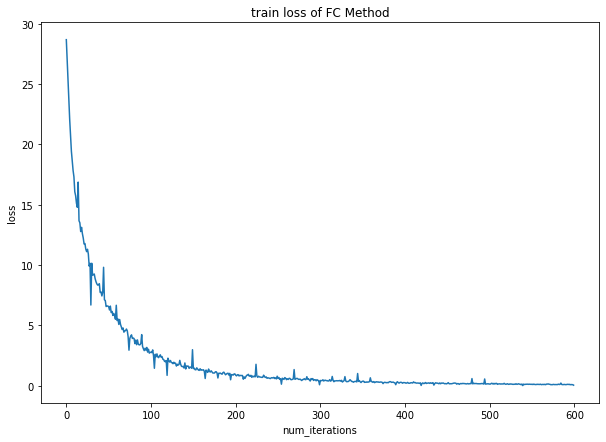

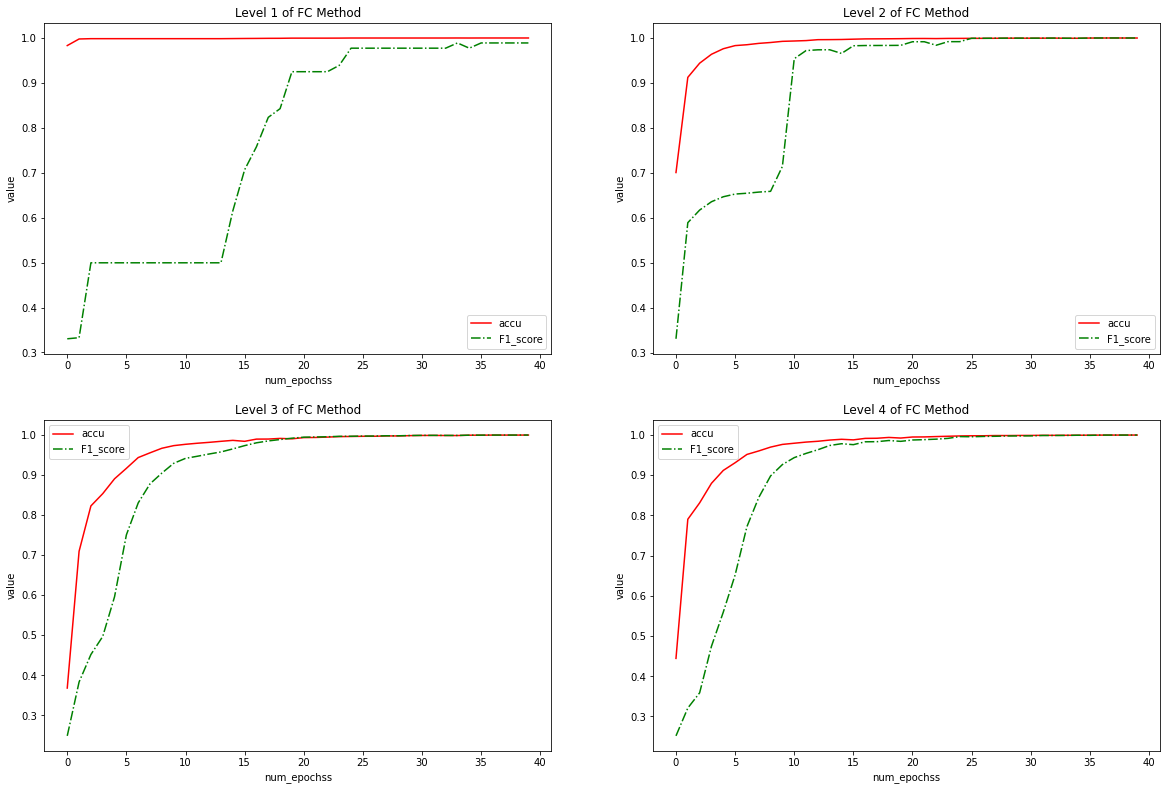

In [34]:
plt.figure(figsize=(10,7))
plt.plot(loss_list)
plt.xlabel("num_iterations")
plt.ylabel("loss")
plt.title("train loss of FC Method")
plt.show()

plt.figure(figsize=(10*2,7*4))
for i in range(4):
    plt.subplot(4,2,i+1)
    plt.title("Level %d of FC Method"%(i+1))
    plt.plot(accu_list[i], "-", color="red", label = "accu")
    plt.plot(f1_list[i], "-.", color="green", label = "F1_score")
    plt.xlabel("num_epochss")
    plt.ylabel("value")
    plt.legend()
plt.show()

In [51]:
def valid(model = model, classifiers = classifiers, criterion = criterion, dataloader = dataloader_valid, label_df = valid_label_df):
    model.eval()

    val_preds = []
    val_labels = []
    for i in range(len(classifiers)):
        val_preds.append(None)
        val_labels.append(None)
    for step, batch in enumerate(dataloader):
        data = batch[0].to(device)
        label = batch[1]
        for i in range(len(label)):
            label[i] = label[i].to(device)
            if val_labels[i] is None:
                val_labels[i] = label[i].clone().squeeze(-1).data.cpu().argmax(dim=1)
            else:
                val_labels[i] = torch.cat((val_labels[i], label[i].clone().squeeze(-1).data.cpu().argmax(dim=1)), dim=0)
                
        with torch.no_grad():       
            output = model(data)
            loss = None
            for i in range(len(classifiers)):
                result = classifiers[i](output)
                preds = torch.softmax(result, dim=1).data.cpu().argmax(dim=1)
                if(val_preds[i] is None):
                    val_preds[i] = preds
                else:
                    val_preds[i] = torch.cat((val_preds[i], preds), dim=0)
        
    level_f1 = []
    level_accu = []
    for i in range(len(classifiers)):
        level_f1.append(f1_score(val_labels[i], val_preds[i], average="macro"))
        level_accu.append(accuracy_score(val_labels[i], val_preds[i]))
        print("level%d, accu = %.4f, f1_score = %.4f"%(i+1, level_accu[i], level_f1[i]))
    
    label_pd = label_df.copy()
    for i in range(len(classifiers)):
        for j in range(label_pd.shape[0]):
            label_pd.iloc[j,i] = level_label_value[i+1][val_preds[i][j].item()]
    label_pd = label_pd.drop(label_pd.columns[[i for i in range(4, label_pd.shape[1])]], axis=1)
    label_pd.columns = ["cell_type_level%d"%(i+1) for i in range(len(classifiers))]
    return label_pd

In [52]:
print("valid results:")
valid_preds = valid()
valid_preds.to_csv("./menon_validation_preds_FC.csv")

valid results:
level1, accu = 1.0000, f1_score = 1.0000
level2, accu = 0.9977, f1_score = 0.9725
level3, accu = 0.9814, f1_score = 0.9669
level4, accu = 0.9810, f1_score = 0.9687


In [63]:
def test(model = model, classifiers = classifiers, criterion = criterion, dataloader = dataloader_test, label_df = test_data_df):
    model.eval()

    val_preds = []
    val_labels = []
    for i in range(len(classifiers)):
        val_preds.append(None)
        val_labels.append(None)
    for step, batch in enumerate(dataloader):
        data = batch[0].to(device)
                
        with torch.no_grad():       
            output = model(data)
            loss = None
            for i in range(len(classifiers)):
                result = classifiers[i](output)
                preds = torch.softmax(result, dim=1).data.cpu().argmax(dim=1)
                if(val_preds[i] is None):
                    val_preds[i] = preds
                else:
                    val_preds[i] = torch.cat((val_preds[i], preds), dim=0)
    
    label_pd = label_df.copy()
    for i in range(len(classifiers)):
        for j in range(label_pd.shape[0]):
            label_pd.iloc[j,i] = level_label_value[i+1][val_preds[i][j].item()]
    label_pd = label_pd.drop(label_pd.columns[[i for i in range(4, label_pd.shape[1])]], axis=1)
    label_pd.columns = ["cell_type_level%d"%(i+1) for i in range(len(classifiers))]
    return label_pd

In [64]:
test_preds = test()
test_preds.to_csv("./lukowski_test_preds_FC.csv")

# 可视化与聚类

In [40]:
def get_embedding(model = model, classifiers = classifiers, dataloader = dataloader_train):
    flag = torch.tensor(-1)
    model.eval()
    
    embedding = None
    labels = []
    for i in range(len(classifiers)):
        labels.append(None)
    
    for step, batch in enumerate(dataloader):
        data = batch[0].to(device)
        label = batch[1]
        if(not label[0].dtype == flag.dtype):
            for i in range(len(label)):
                label[i] = label[i].to(device)
                if labels[i] is None:
                    labels[i] = label[i].clone().squeeze(-1).data.cpu()
                else:
                    labels[i] = torch.cat((labels[i], label[i].clone().squeeze(-1).data.cpu()), dim=0)
        
        with torch.no_grad():       
            output = model(data)
            if(embedding is None):
                embedding = output.data.cpu()
            else:
                embedding = torch.cat((embedding, output.data.cpu()), dim=0)
                
    embedding = np.array(embedding)
    if(not label[0].dtype == flag.dtype):
        for i in range(len(labels)):
            labels[i] = np.array(labels[i])
    
    return embedding, labels

In [41]:
def get_data(classifiers = classifiers, dataloader = dataloader_train):
    flag = torch.tensor(-1)
    model.eval()
    
    embedding = None
    labels = []
    for i in range(len(classifiers)):
        labels.append(None)
    
    for step, batch in enumerate(dataloader):
        data = batch[0].to(device)
        label = batch[1]
        if(embedding is None):
            embedding = data.data.cpu()
        else:
            embedding = torch.cat((embedding, data.data.cpu()), dim=0)
        
        if(not label[0].dtype == flag.dtype):
            for i in range(len(label)):
                
                label[i] = label[i].to(device)
                if labels[i] is None:
                    labels[i] = label[i].clone().squeeze(-1).data.cpu()
                else:
                    labels[i] = torch.cat((labels[i], label[i].clone().squeeze(-1).data.cpu()), dim=0)

                
    embedding = np.array(embedding)
    if(not label[0].dtype == flag.dtype):
        for i in range(len(labels)):
            labels[i] = np.array(labels[i])
    
    return embedding, labels

In [42]:
data_train, labels_train = get_data()
data_valid, labels_valid = get_data(dataloader = dataloader_valid)
data_test, labels_test = get_data(dataloader = dataloader_test)

In [43]:
__tsne = TSNE(n_components=2, n_iter=1000, metric='euclidean', random_state = 42)
__dots = __tsne.fit_transform(data_train)
__tsne2 = TSNE(n_components=2, n_iter=1000, metric='euclidean', random_state = 42)
__dots_tr_val = __tsne2.fit_transform(np.concatenate([data_train, data_valid], axis=0))
__tsne3 = TSNE(n_components=2, n_iter=1000, metric='euclidean', random_state = 42)
__dots_tr_val_te = __tsne3.fit_transform(np.concatenate([data_train, data_valid, data_test], axis=0))

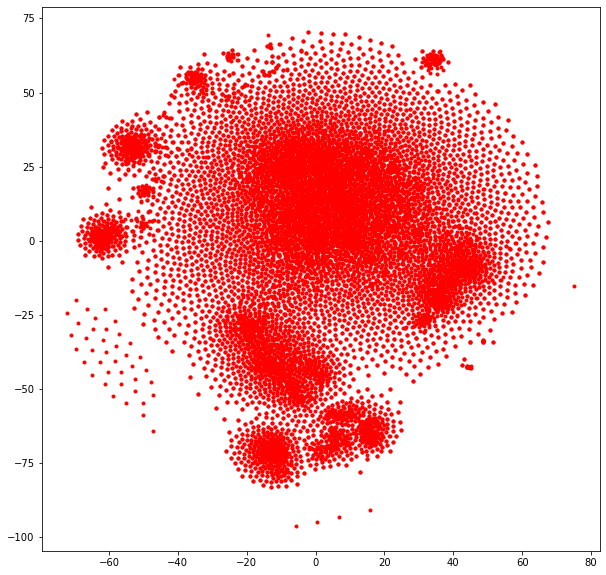

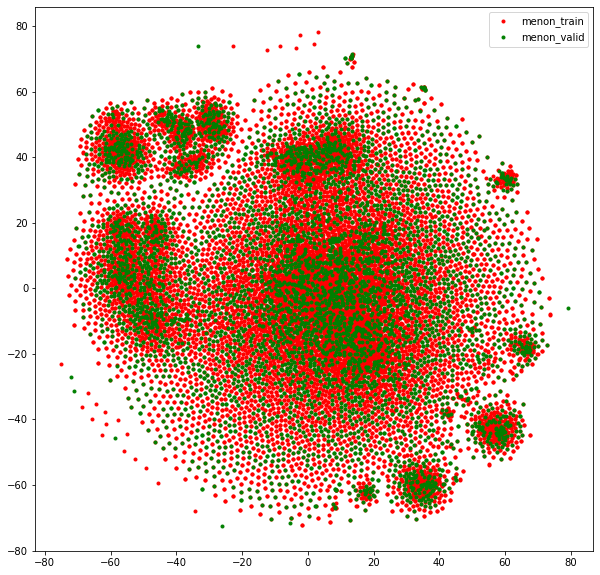

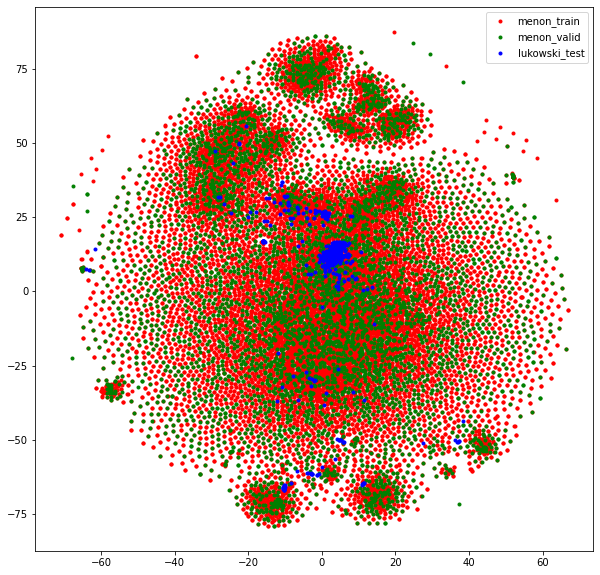

In [44]:
plt.figure(figsize=(10,10))
plt.plot(__dots[:,0],__dots[:,1],".", color = "red")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(__dots_tr_val[:data_train.shape[0],0],__dots_tr_val[:data_train.shape[0],1],".", color = "red", label = "menon_train")
plt.plot(__dots_tr_val[data_train.shape[0]:,0],__dots_tr_val[data_train.shape[0]:,1],".", color = "green", label = "menon_valid")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
index1 = data_train.shape[0]
index2 = data_train.shape[0]+data_valid.shape[0]
plt.plot(__dots_tr_val_te[:index1,0],__dots_tr_val_te[:index1,1],".", color = "red", label = "menon_train")
plt.plot(__dots_tr_val_te[index1:index2,0],__dots_tr_val_te[index1:index2,1],".", color = "green", label = "menon_valid")
plt.plot(__dots_tr_val_te[index2:,0],__dots_tr_val_te[index2:,1],".", color = "blue", label = "lukowski_test")
plt.legend()
plt.show()

## train_data

In [45]:
embedding_train, labels_train = get_embedding()

In [46]:
_tsne = TSNE(n_components=2, n_iter=1000, metric='euclidean', random_state = 42)
_dots = _tsne.fit_transform(embedding_train)

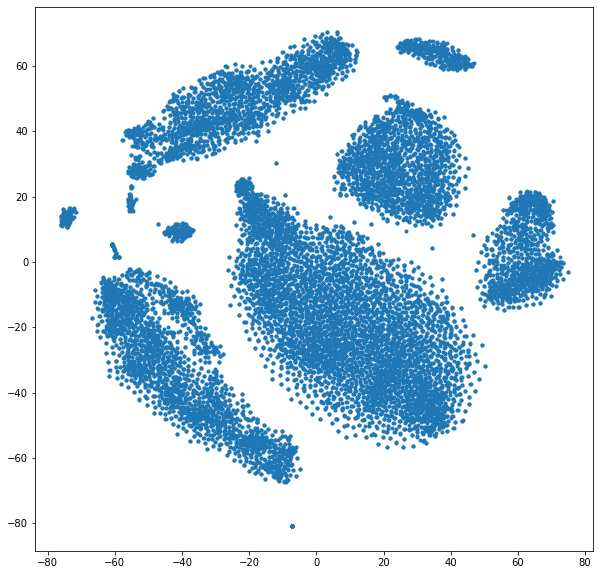

In [47]:
plt.figure(figsize=(10,10))
plt.plot(_dots[:,0],_dots[:,1],".")
plt.show()

In [48]:
tsne = TSNE(n_components=2, n_iter=1000, metric='cosine', random_state = 42)
dots = tsne.fit_transform(embedding_train)

/home/cuiyanfei/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


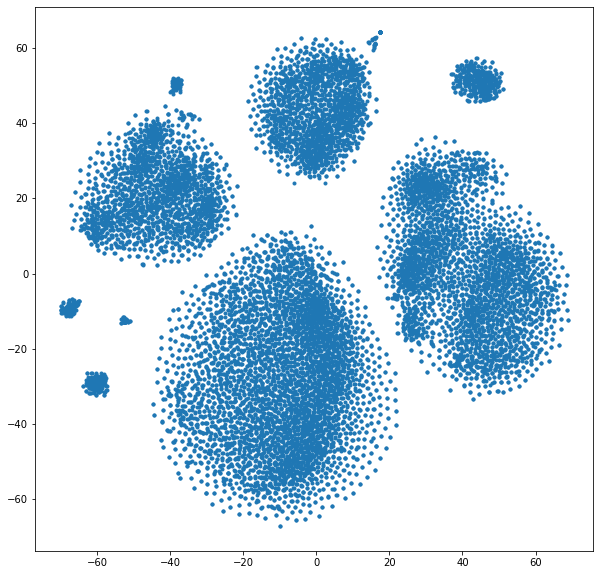

In [49]:
plt.figure(figsize=(10,10))
plt.plot(dots[:,0],dots[:,1],".")
plt.show()

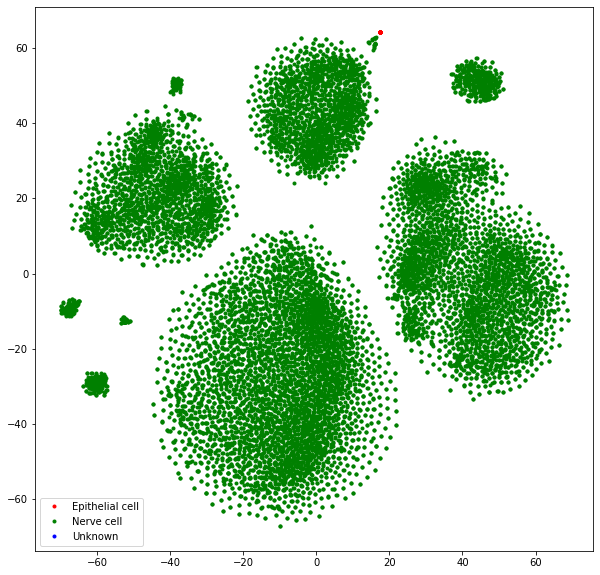

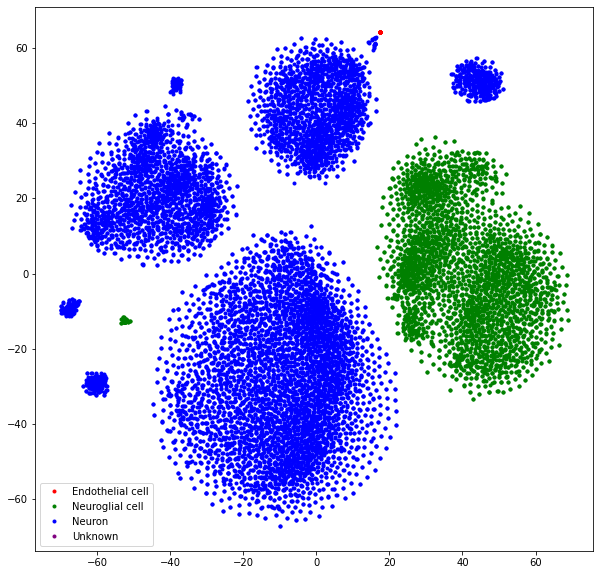

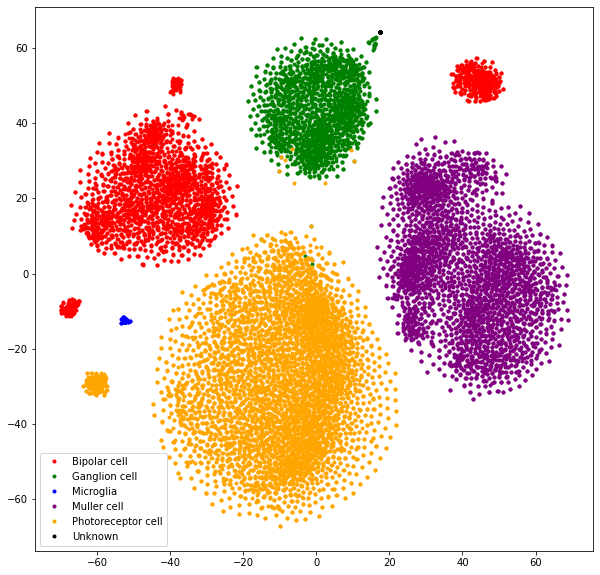

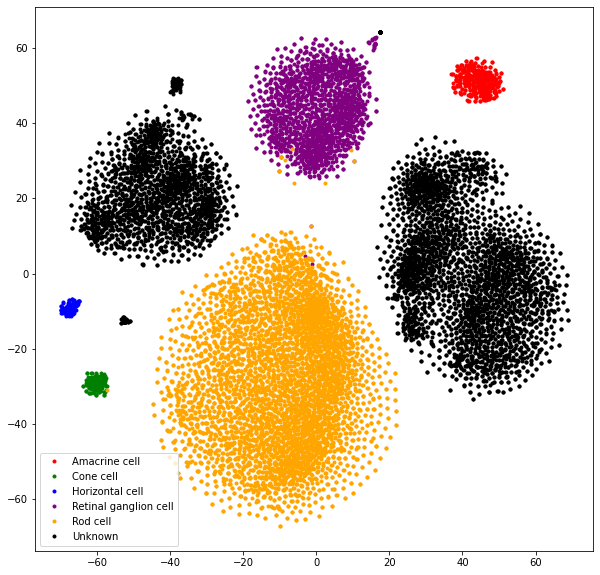

In [50]:
for level in range(len(level_label_value)-1):
    plt.figure(figsize=(10,10))
    colors = ["red", "green", "blue", "purple", "orange", "black"]
    for i in range(labels_train[level].shape[1]):
        tmp_label = level_label_value[level+1][i]
        idxs = np.where(labels_train[level][:, i]==1)[0]
        plt.plot(dots[idxs,0], dots[idxs,1], ".", color=colors[i], label=tmp_label)
    plt.legend(loc='lower left')
    plt.show()